In [1]:
!pip install yfinance 

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [17]:
import yfinance as yf
import  warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # autocorrelation and partial autocorrelation plots
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [14]:
stock_data = yf.download('AAPL',start='2024-01-01')

[*********************100%***********************]  1 of 1 completed


In [18]:
stock_data

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-01-02,184.532074,187.315366,182.792518,186.033057,82488700
2024-01-03,183.150375,184.770652,182.335262,183.120556,58414500
2024-01-04,180.824356,181.997307,179.800504,181.062914,71983600
2024-01-05,180.098694,181.669266,179.094727,180.903872,62303300
2024-01-08,184.452560,184.492330,180.416793,181.003268,59144500
...,...,...,...,...,...
2025-04-11,198.149994,199.539993,186.059998,186.100006,87435900
2025-04-14,202.520004,212.940002,201.160004,211.440002,101352900


Text(0, 0.5, 'close price')

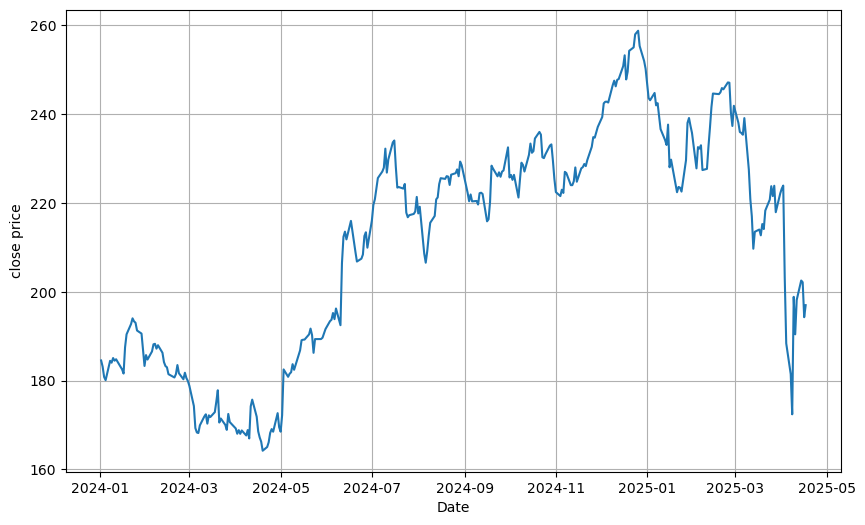

In [28]:
plt.figure(figsize=(10,6))
plt.plot(stock_data.index,stock_data['Close'])
plt.grid()
plt.xlabel('Date')
plt.ylabel('close price')

# classical time series decomposition

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose 

In [30]:
additive_decompose = seasonal_decompose(stock_data['Close'],model='additve',period=30)
trend = additive_decompose.trend
seasonality = additive_decompose.seasonal
resid = additive_decompose.resid

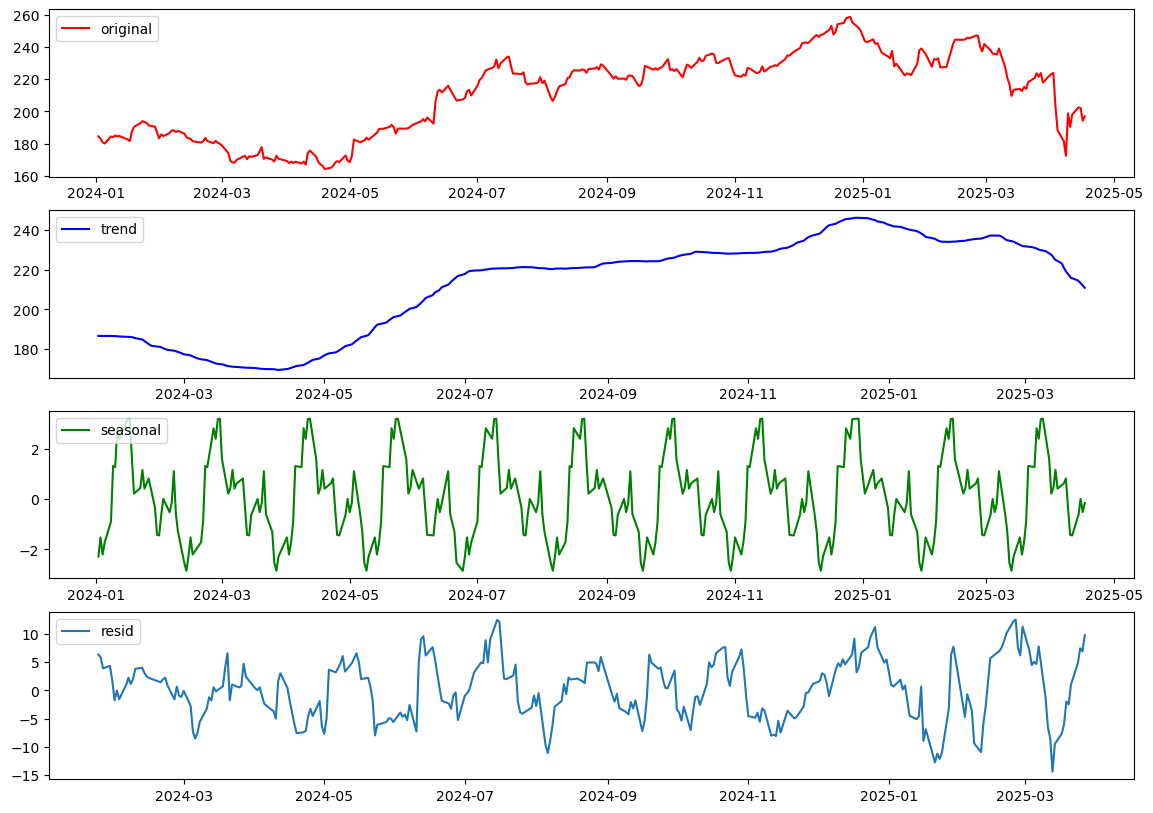

In [31]:
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(stock_data['Close'],label='original',color='r')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend,label='trend',color='b')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonality,label='seasonal',color='g')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(resid,label='resid')
plt.legend(loc='upper left')

# ADF

In [32]:
from statsmodels.tsa.stattools import adfuller

In [33]:
adf_test = adfuller(stock_data['Close'])
print('ADF Test Result:')
print(f'ADF statistic : {round(adf_test[0],3)}')
print(f'p-value : {round(adf_test[1],3)}')
print('critical value')
for key,value in adf_test[4].items():
    print(f'{key}:{round(value,3)}')

ADF Test Result:
ADF statistic : -1.52
p-value : 0.524
critical value
1%:-3.451
5%:-2.871
10%:-2.572


In [34]:
#interpret the results
if adf_test[1] <= 0.05:
  print("Time Series Data is Stationary")
else:
  print("Time Series Data is Non-Stationary, Differencing is required")

Time Series Data is Non-Stationary, Differencing is required


In [35]:
#data has a unit root (non-stationary)

# making stationary data

In [36]:
def adf_test(series):
    series = series.dropna()
    result = adfuller(series)
    print('ADF Test Result:')
    print(f'ADF statistic : {round(result[0],3)}')
    print(f'p-value : {round(result[1],3)}')
    print('critical value')
    for key,value in result[4].items():
        print(f'{key}:{round(value,3)}')
    print('--'*30)
    if result[1] <= 0.05:
        print("Time Series Data is Stationary")
    else:
        print("Time Series Data is Non-Stationary, Differencing is required")

In [37]:

prices = stock_data['Close']
adf_test(prices)

ADF Test Result:
ADF statistic : -1.52
p-value : 0.524
critical value
1%:-3.451
5%:-2.871
10%:-2.572
------------------------------------------------------------
Time Series Data is Non-Stationary, Differencing is required


In [38]:
#differencig 
prices_diff = prices.diff()

adf_test(prices_diff)

ADF Test Result:
ADF statistic : -10.613
p-value : 0.0
critical value
1%:-3.451
5%:-2.871
10%:-2.572
------------------------------------------------------------
Time Series Data is Stationary


In [39]:
prices_diff

Ticker,AAPL
Date,
2024-01-02,NaN
2024-01-03,-1.381699
2024-01-04,-2.326019
2024-01-05,-0.725662
2024-01-08,4.353867
...,...
2025-04-11,7.729996
2025-04-14,4.370010
2025-04-15,-0.380005


# TIME SERIES FORECASTING MODELS

# AR MODEL

In [40]:
stock_data = yf.download('AAP',start='2023-01-01')
apple_price_stationary = stock_data['Close'].diff().dropna()

#split the  datasets into training and testing
train_data ,  test_data = apple_price_stationary[:-30] ,apple_price_stationary[-30:]

[*********************100%***********************]  1 of 1 completed


In [41]:
apple_price_stationary.shape

(574, 1)

In [42]:
train_data.shape ,  test_data.shape

((544, 1), (30, 1))

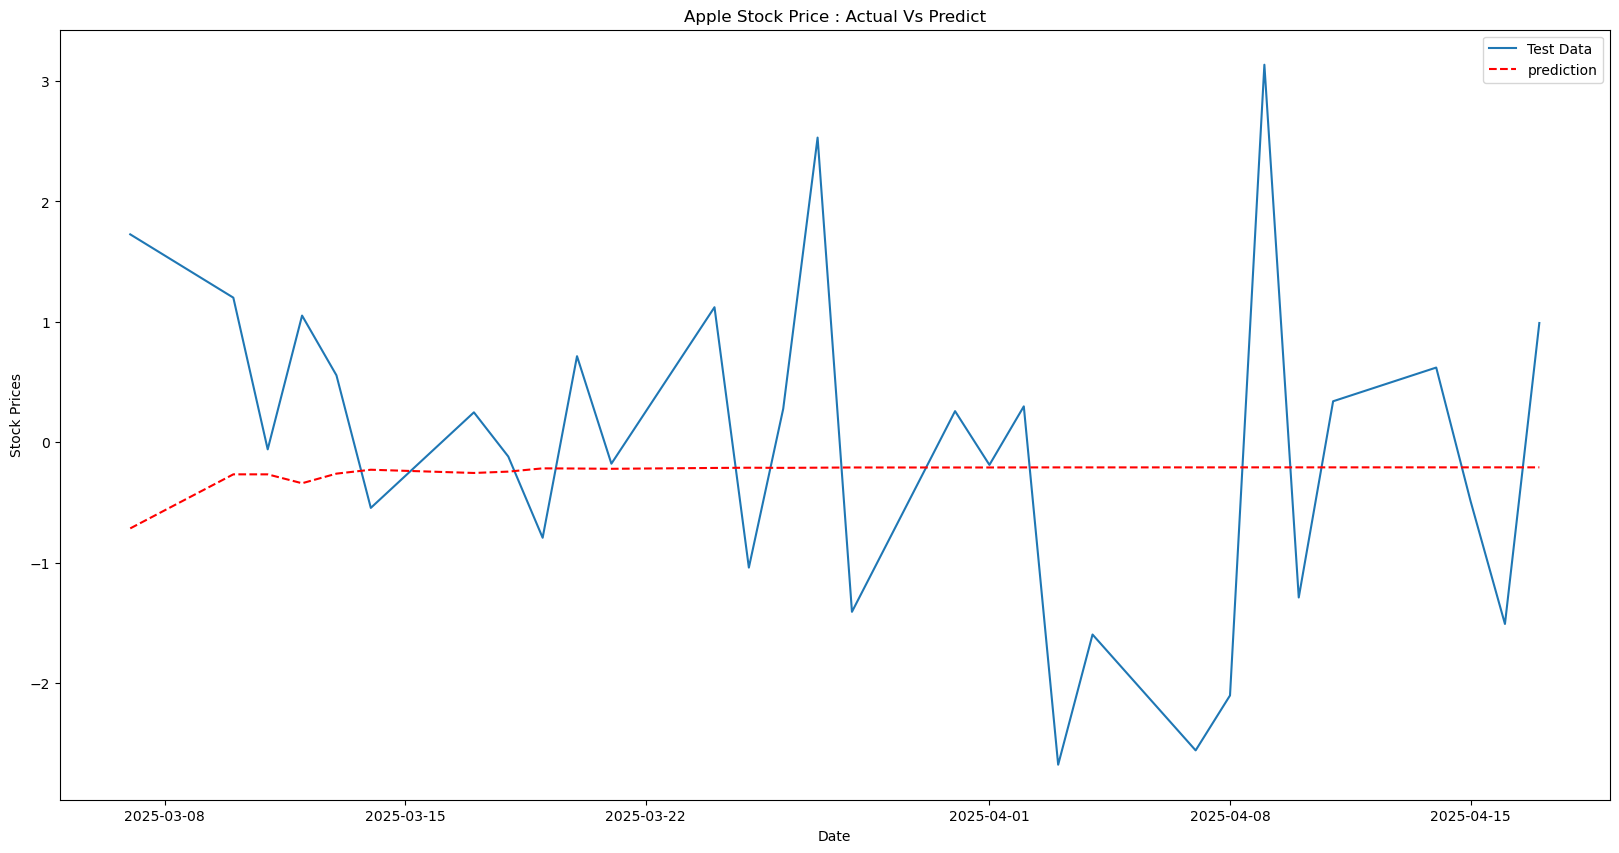

RMSE Score: 1.39


In [43]:
from statsmodels.tsa.ar_model import  AutoReg
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import numpy as np

#fit the  autoreg model(AR) to the training data
model = AutoReg(train_data,lags=7)
model_fit = model.fit()

#make prediction on test_data
prediction = model_fit.predict(start=len(train_data),end=len(train_data) + len(test_data)-1,dynamic=False)

#plot the  actual vs predicted
plt.figure(figsize=(20,10))
plt.plot(test_data.index , test_data , label='Test Data')
plt.plot(test_data.index , prediction , label='prediction',color='r',linestyle='--')
plt.title('Apple Stock Price : Actual Vs Predict')
plt.xlabel('Date')
plt.ylabel('Stock Prices')
plt.legend()
plt.show()

#evaluating model using rmse score
rmse = round(np.sqrt(mean_squared_error(test_data,prediction)),2)
print('RMSE Score:',rmse)

# MA MODEL

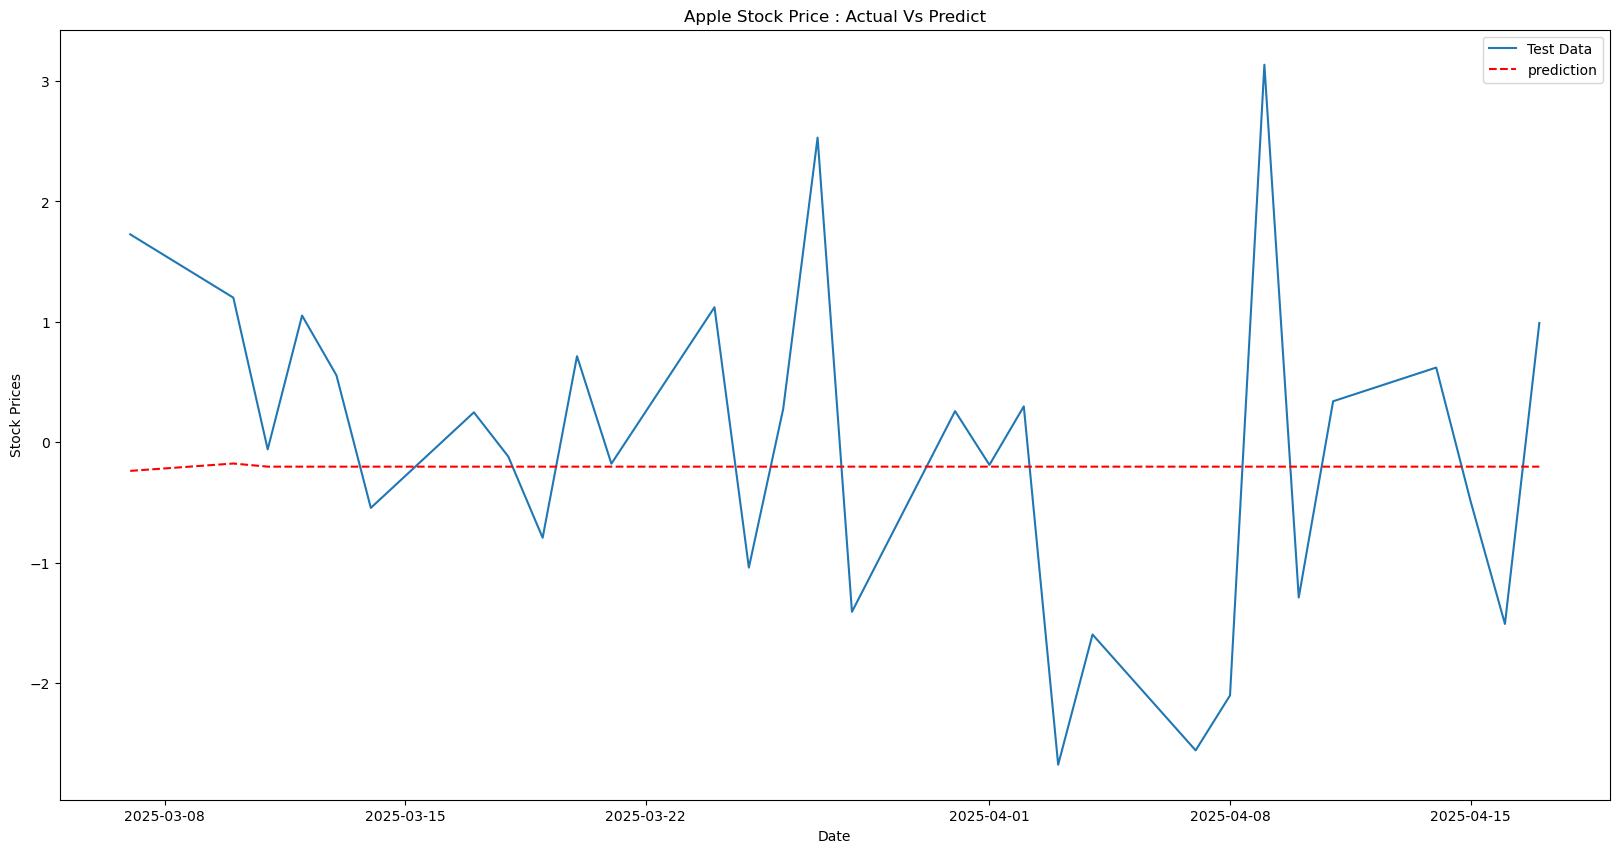

RMSE Score: 1.36


In [44]:
from statsmodels.tsa.arima.model import ARIMA
#fit the  MA model(MA) to the training data
model = ARIMA(train_data,order=(0,0,2))
model_fit = model.fit()

#make prediction on test_data
prediction = model_fit.predict(start=len(train_data),end=len(train_data) + len(test_data)-1,dynamic=False)

#plot the  actual vs predicted
plt.figure(figsize=(20,10))
plt.plot(test_data.index , test_data , label='Test Data')
plt.plot(test_data.index , prediction , label='prediction',color='r',linestyle='--')
plt.title('Apple Stock Price : Actual Vs Predict')
plt.xlabel('Date')
plt.ylabel('Stock Prices')
plt.legend()
plt.show()

#evaluating model using rmse score
rmse = round(np.sqrt(mean_squared_error(test_data,prediction)),2)
print('RMSE Score:',rmse)

# ARMA MODEL

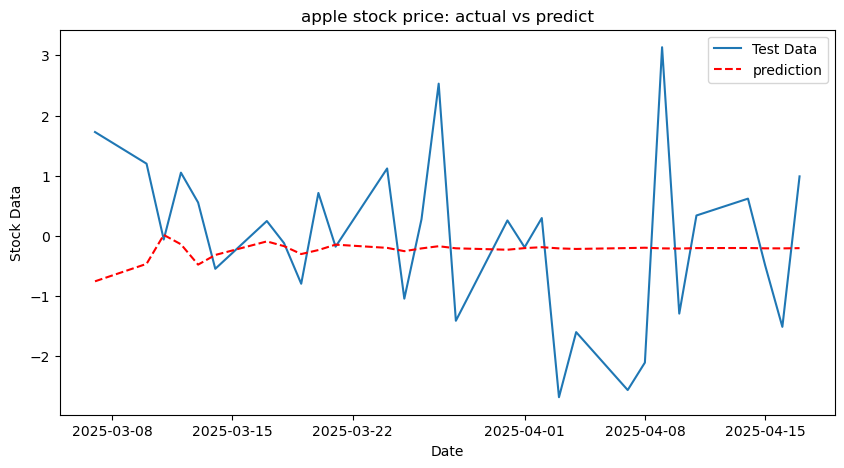

RMSE Score: 1.39


In [46]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data,order=(7,0,2))
model_fit = model.fit()

prediction = model_fit.predict(start=len(train_data),end=len(train_data)+len(test_data)-1,dynamic=False)

#plot the actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(test_data.index,test_data,label='Test Data')
plt.plot(test_data.index,prediction,color='r',linestyle='--',label='prediction')
plt.title('apple stock price: actual vs predict')
plt.xlabel('Date')
plt.ylabel('Stock Data')
plt.legend()
plt.show()

rmse =  round(np.sqrt(mean_squared_error(test_data,prediction)),2)
print('RMSE Score:',rmse)

# ARIMA MODEL

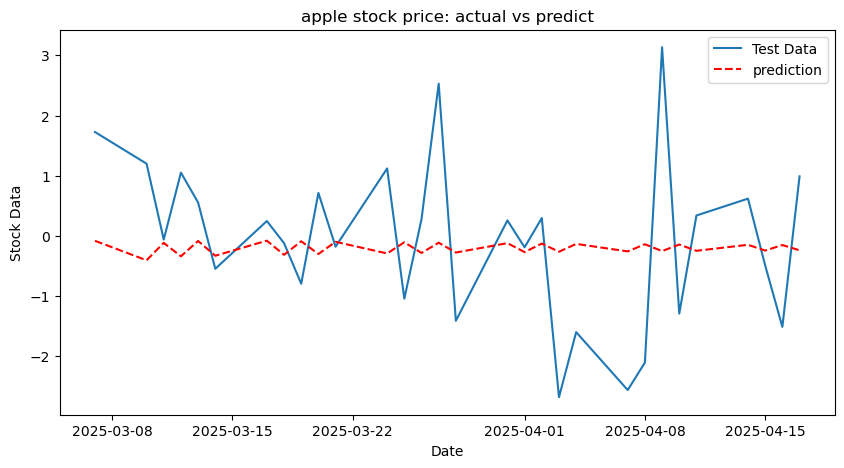

RMSE Score: 1.37


In [47]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data,order=(7,1,2))
model_fit = model.fit()

prediction = model_fit.predict(start=len(train_data),end=len(train_data)+len(test_data)-1,dynamic=False)

#plot the actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(test_data.index,test_data,label='Test Data')
plt.plot(test_data.index,prediction,color='r',linestyle='--',label='prediction')
plt.title('apple stock price: actual vs predict')
plt.xlabel('Date')
plt.ylabel('Stock Data')
plt.legend()
plt.show()

rmse =  round(np.sqrt(mean_squared_error(test_data,prediction)),2)
print('RMSE Score:',rmse)

# SARIMA MODEL

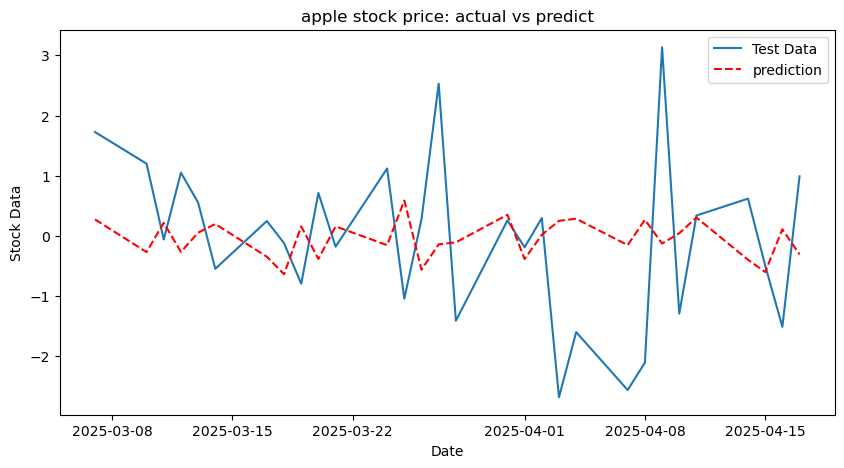

RMSE Score: 1.47


In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
p,d,q = 7,1,2
P,D,Q,s = 1,1,1,20
model = SARIMAX(train_data,order=(p,d,q),seasonal_order = (P,D,Q,s))
model_fit = model.fit()

prediction = model_fit.predict(start=len(train_data),end=len(train_data)+len(test_data)-1,dynamic=False)

#plot the actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(test_data.index,test_data,label='Test Data')
plt.plot(test_data.index,prediction,color='r',linestyle='--',label='prediction')
plt.title('apple stock price: actual vs predict')
plt.xlabel('Date')
plt.ylabel('Stock Data')
plt.legend()
plt.show()

rmse =  round(np.sqrt(mean_squared_error(test_data,prediction)),2)
print('RMSE Score:',rmse)

# Smoothning Method

# Moving Average

In [49]:
windowsize=20
stock_data['SMA'] = stock_data['Close'].rolling(window=windowsize).mean()

#calculated weighted moving average
weights = np.arange(1,windowsize+1)
stock_data['WMA'] = stock_data['Close'].rolling(windowsize).apply(lambda prices : np.dot(prices,weights)/weights.sum(),raw=True)

#calculate Exponential Moving AVG
stock_data['EMA'] = stock_data['Close'].ewm(span=windowsize).mean()

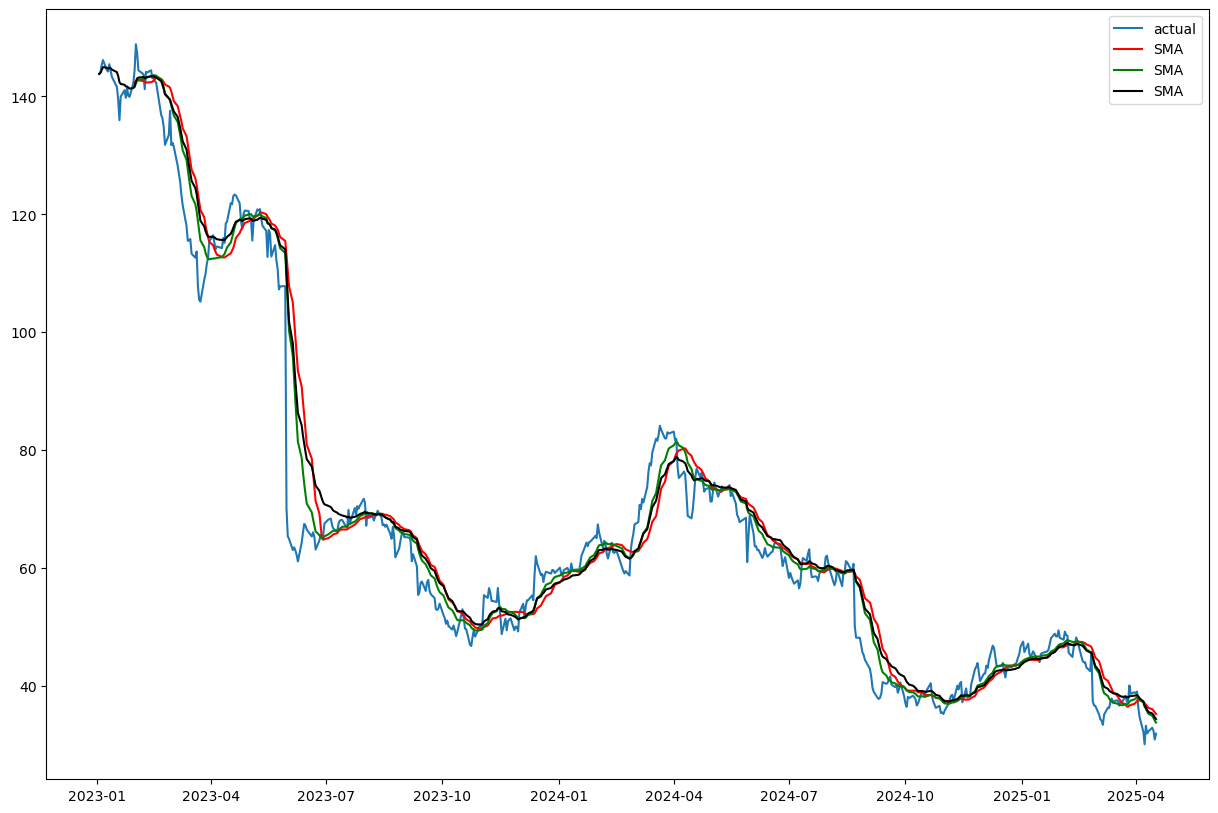

In [51]:
plt.figure(figsize=(15,10))
plt.plot(stock_data['Close'],label='actual')
plt.plot(stock_data['SMA'],label='SMA',color='r')
plt.plot(stock_data['WMA'],label='SMA',color='green')
plt.plot(stock_data['EMA'],label='SMA',color='black')


plt.legend()
plt.show()


# ACF AND PACF PLOT

In [52]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [53]:
stock_data

Price,Close,High,Low,Open,Volume,SMA,WMA,EMA
Ticker,AAP,AAP,AAP,AAP,AAP,,,
Date,,,,,,,,
2023-01-03,143.823746,143.937645,138.565843,138.717699,1307400,NaN,NaN,143.823746
2023-01-04,144.155914,146.633016,143.206833,144.953139,834200,NaN,NaN,143.998134
2023-01-05,145.361282,146.576105,142.248297,142.789266,795700,NaN,NaN,144.498674
2023-01-06,146.177475,147.809896,145.522607,145.845291,718200,NaN,NaN,144.983318
2023-01-09,144.507111,147.221484,144.402711,146.186989,781200,NaN,NaN,144.868127
...,...,...,...,...,...,...,...,...
2025-04-11,32.259998,32.639999,30.639999,31.740000,2917600,36.262126,35.239446,35.555915
2025-04-14,32.880001,33.049999,31.760000,32.970001,1837300,36.028829,34.917339,35.301066


Text(0.5, 1.0, 'PACF Plot of APPLe close ')

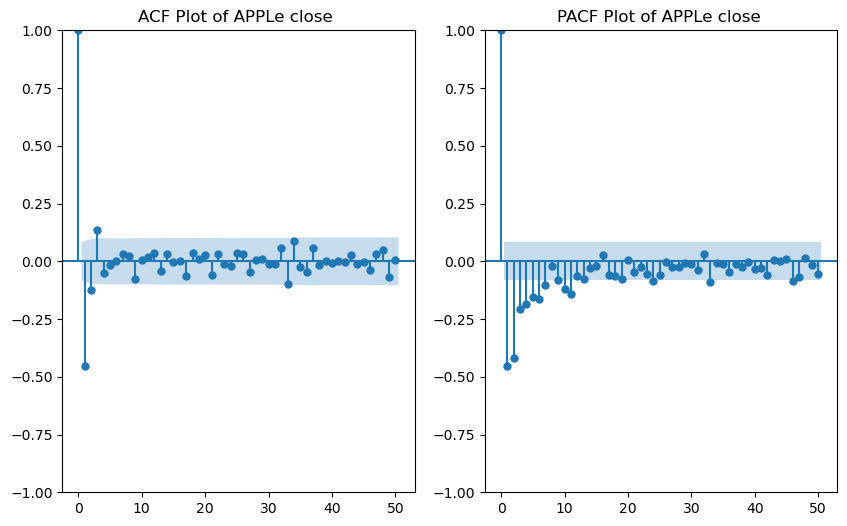

In [54]:
plt.figure(figsize=(10,6))
#acf plot
plt.subplot(1,2,1)
plot_acf(stock_data['Close'].diff().diff().dropna(),ax=plt.gca(),lags=50)
plt.title('ACF Plot of APPLe close ')

#pacf plot
plt.subplot(1,2,2)
plot_pacf(stock_data['Close'].diff().diff().dropna(),ax=plt.gca(),lags=50,method='ywm')
plt.title('PACF Plot of APPLe close ')
